# Predict Bank Of America Stock Price Using ML and Macroeconomic Variables
This notebook predicts **Bank of America (BAC)** stock prices using machine learning models and macroeconomic variables.

In [1]:
# Import necessary data science packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


## Download the data

In [2]:

# Download the data from Yahoo Finance
tickers = ['BAC','JPM','MS','C','WFC','SPY','^VIX','^TNX','DX-Y.NYB','CL=F','GC=F']
data = yf.download(tickers, start='2002-01-01', end='2025-01-01')['Close']

#data.info()
#data.describe()


C:\Users\Startklar\AppData\Local\Temp\ipykernel_20340\3423717355.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2002-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  11 of 11 completed


## Fix the data 

In [3]:

# How many missing values are present in the dataset
data.isnull().sum()

# Handling missing data - Forward Fill
data = data.ffill()

# Verify missing values again
data.isnull().sum()


Ticker
BAC         0
C           0
CL=F        0
DX-Y.NYB    0
GC=F        0
JPM         0
MS          0
SPY         0
WFC         0
^TNX        0
^VIX        0
dtype: int64

In [4]:

# Correlation matrix
data.corr()


Ticker,BAC,C,CL=F,DX-Y.NYB,GC=F,JPM,MS,SPY,WFC,^TNX,^VIX
Ticker,,,,,,,,,,,
BAC,1.000000,0.461779,-0.070637,0.360871,0.071502,0.569557,0.786216,0.544844,0.342323,0.381009,-0.214983
C,0.461779,1.000000,-0.328865,-0.056293,-0.753355,-0.404546,-0.078854,-0.429433,-0.509659,0.716295,-0.165584
CL=F,-0.070637,-0.328865,1.000000,-0.513374,0.436498,0.117551,0.110137,0.140270,0.149889,-0.045080,-0.111997
DX-Y.NYB,0.360871,-0.056293,-0.513374,1.000000,0.165210,0.527508,0.509171,0.542913,0.449883,0.055238,0.003703
GC=F,0.071502,-0.753355,0.436498,0.165210,1.000000,0.787185,0.581200,0.810607,0.694652,-0.526051,-0.022830
JPM,0.569557,-0.404546,0.117551,0.527508,0.787185,1.000000,0.902370,0.987253,0.834764,-0.196493,-0.136455
MS,0.786216,-0.078854,0.110137,0.509171,0.581200,0.902370,1.000000,0.901737,0.660625,0.098139,-0.153446
SPY,0.544844,-0.429433,0.140270,0.542913,0.810607,0.987253,0.901737,1.000000,0.824806,-0.243903,-0.126401
WFC,0.342323,-0.509659,0.149889,0.449883,0.694652,0.834764,0.660625,0.824806,1.000000,-0.322967,-0.333026


## Visualize the data

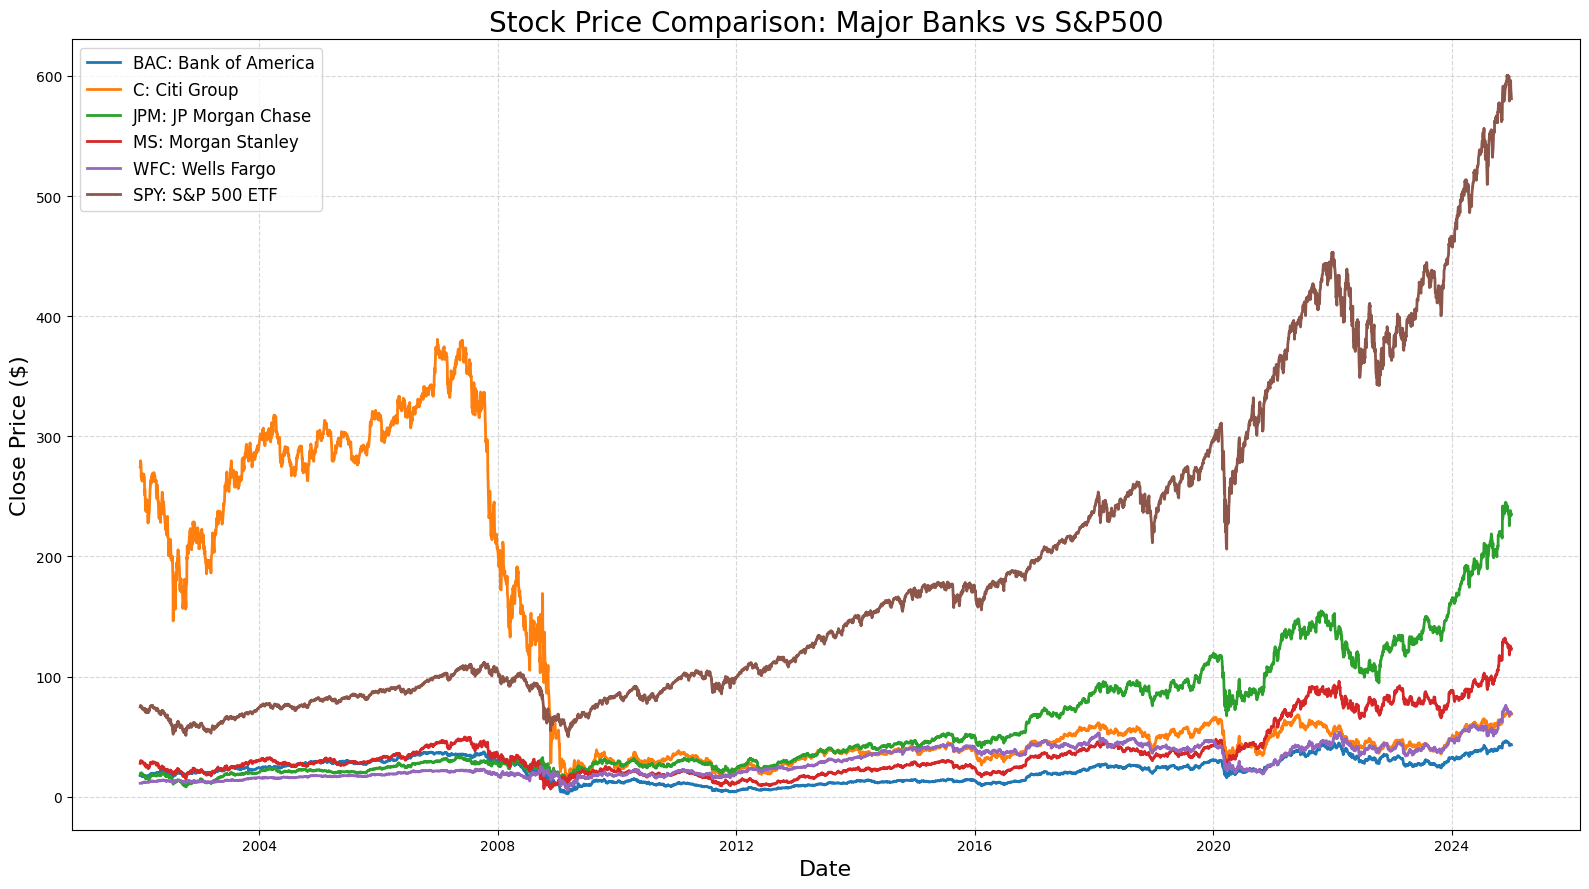

In [5]:
plt.figure(figsize=(16,9))
plt.plot(data.index, data['BAC'], label='BAC: Bank of America', linewidth=2)
plt.plot(data.index, data['C'], label='C: Citi Group', linewidth=2)
plt.plot(data.index, data['JPM'], label='JPM: JP Morgan Chase', linewidth=2)
plt.plot(data.index, data['MS'], label='MS: Morgan Stanley', linewidth=2)
plt.plot(data.index, data['WFC'], label='WFC: Wells Fargo', linewidth=2)
plt.plot(data.index, data['SPY'], label='SPY: S&P 500 ETF', linewidth=2)

plt.title('Stock Price Comparison: Major Banks vs S&P500', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price ($)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()


## Feature Engineering

In [6]:
df = pd.DataFrame(index=data.index)

# Lag features
df['JPM(t-1)'] = data['JPM'].shift(1)
df['BAC(t-1)'] = data['BAC'].shift(1)
df['MS(t-1)'] = data['MS'].shift(1)
df['C(t-1)'] = data['C'].shift(1)
df['WFC(t-1)'] = data['WFC'].shift(1)
df['SPY(t-1)'] = data['SPY'].shift(1)

# Macroeconomic lag features
df['VIX(t-1)'] = data['^VIX'].shift(1)
df['10Y_Yield(t-1)'] = data['^TNX'].shift(1)
df['Gold_Futures(t-1)'] = data['GC=F'].shift(1)
df['US_Dollar_Index(t-1)'] = data['DX-Y.NYB'].shift(1)
df['Crude_Oil_Futures(t-1)'] = data['CL=F'].shift(1)

# Technical indicators
df['BAC_MA5'] = data['BAC'].rolling(window=5).mean().shift(1)
df['BAC_MA10'] = data['BAC'].rolling(window=10).mean().shift(1)
df['BAC_Volatility5'] = data['BAC'].pct_change(5).shift(1)

# Target variable
df['Target'] = data['BAC']

# Drop missing values
df = df.dropna()
#df.head()

In [7]:

# Split data into X and Y
X = df.drop('Target', axis=1)
Y = df['Target']

# Train-test split (90:10)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)

# Apply models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

dt_model = DecisionTreeRegressor(max_depth=4)
rf_model = RandomForestRegressor(n_estimators=100)
knn_model = KNeighborsRegressor(n_neighbors=5)
svr_model = SVR()

dt_model.fit(X_train, Y_train)
rf_model.fit(X_train, Y_train)
knn_model.fit(X_train, Y_train)
svr_model.fit(X_train, Y_train)

# Predictions
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
svr_pred = svr_model.predict(X_test)


## Evaluation metrics

In [8]:
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"Model Name: {model_name}")
    print("R2 Value:", r2)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("\n")

evaluate_model(Y_test, dt_pred, "Decision Tree")
evaluate_model(Y_test, rf_pred, "Random Forest")
evaluate_model(Y_test, knn_pred, "K Nearest Neighbor")
evaluate_model(Y_test, svr_pred, "Support Vector Regressor")


Model Name: Decision Tree
R2 Value: 0.9582605567628619
MSE: 1.3086202117500778
RMSE: 1.143949392128025


Model Name: Random Forest
R2 Value: 0.9830947657323607
MSE: 0.5300150057420784
RMSE: 0.728021294841077


Model Name: K Nearest Neighbor
R2 Value: -0.5997256993388278
MSE: 50.15479893963137
RMSE: 7.08200529085028


Model Name: Support Vector Regressor
R2 Value: 0.01069782516114448
MSE: 31.016724736053334
RMSE: 5.569266085944658




## Visualization: Actual vs. Predicted

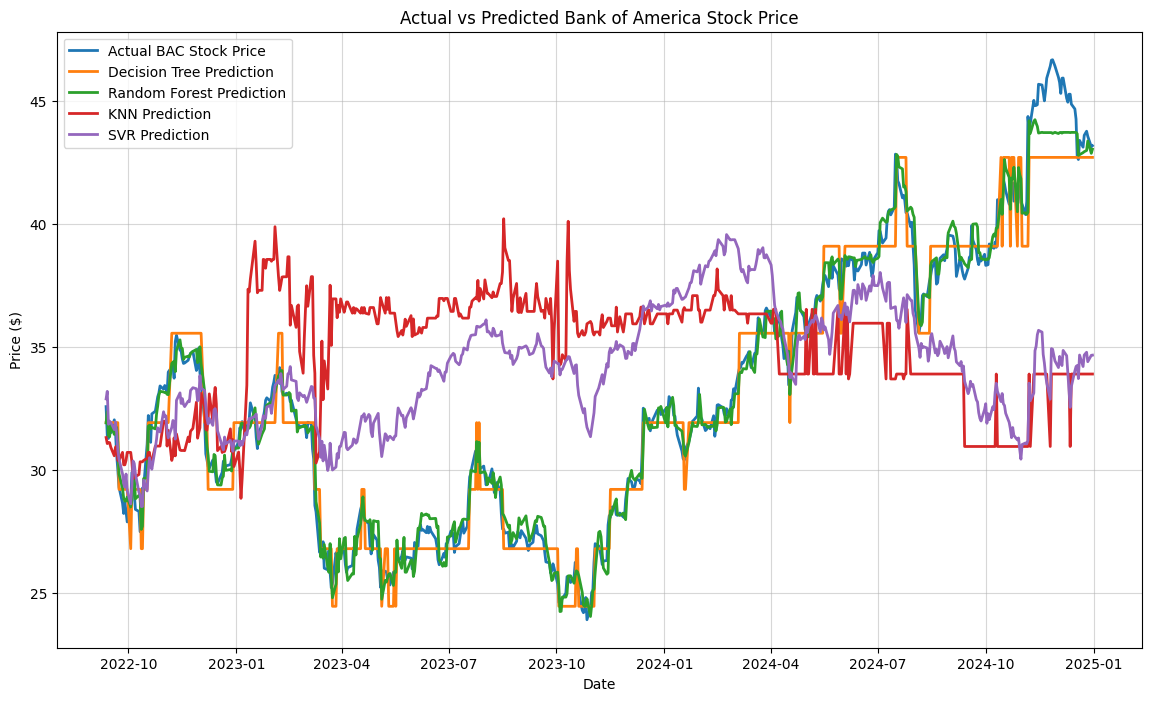

In [9]:

plt.figure(figsize=(14,8))
plt.plot(Y_test.index, Y_test, label='Actual BAC Stock Price', linewidth=2)
plt.plot(Y_test.index, dt_pred, label='Decision Tree Prediction', linewidth=2)
plt.plot(Y_test.index, rf_pred, label='Random Forest Prediction', linewidth=2)
plt.plot(Y_test.index, knn_pred, label='KNN Prediction', linewidth=2)
plt.plot(Y_test.index, svr_pred, label='SVR Prediction', linewidth=2)
plt.title('Actual vs Predicted Bank of America Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(alpha=0.5)
plt.legend()
plt.show()


## Feature Importance

In [10]:
importance = dt_model.feature_importances_
features_name = X_train.columns
df_features = pd.DataFrame({'Feature': features_name, 'Importance': importance})
df_features = df_features.sort_values(by='Importance', ascending=False)
df_features

,Feature,Importance
1,BAC(t-1),1.0
0,JPM(t-1),0.0
2,MS(t-1),0.0
3,C(t-1),0.0
4,WFC(t-1),0.0
5,SPY(t-1),0.0
6,VIX(t-1),0.0
7,10Y_Yield(t-1),0.0
8,Gold_Futures(t-1),0.0
9,US_Dollar_Index(t-1),0.0


## Decision Tree Plot

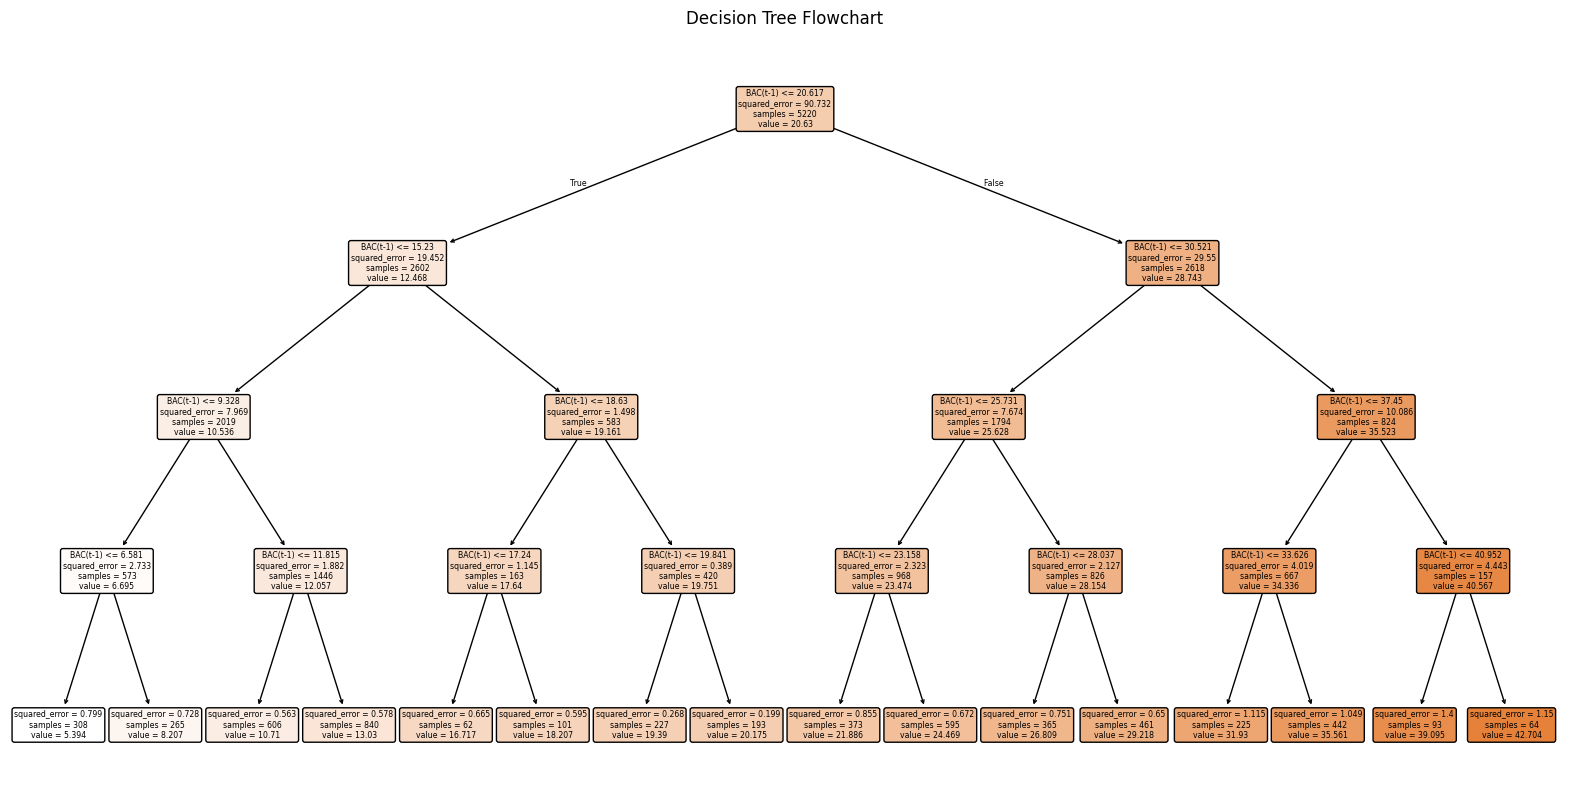

In [11]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Flowchart")
plt.show()